## IMPORTS

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
from glob import glob
import pickle


sys.path.append('../../')
from utils import clustering_utils, bokeh_ui_utils, file_utils, rna_seq_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
full_filtered_df = pd.read_csv('../../active_fastas/rna_seq.csv')
full_filtered_norm_df = rna_seq_utils.normalize_expression_per_gene(full_filtered_df)
full_filtered_norm_df = rna_seq_utils.ari_mean_df_of_duplicates(full_filtered_norm_df)

num_genes = full_filtered_df.shape[0]
num_genes

23112

In [3]:
full_filtered_norm_df.sample(10)

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
15418,TTHERM_00671990,-1.783283,-0.698117,-0.508082,0.419804,1.805341,1.865876,0.523706,-0.299653,-1.564282
8912,TTHERM_00391260,0.678536,0.678194,1.273986,-0.650934,-0.726779,2.169280,-0.310030,0.383356,-0.239816
18125,TTHERM_00825710,0.209019,0.134061,-1.000434,-0.564135,-0.054241,0.693155,1.095174,1.444827,0.398779
7435,TTHERM_00318770,-1.355540,-0.934976,0.237910,1.264411,2.078177,1.848083,0.180345,-0.581310,-1.194906
7619,TTHERM_00327070,-1.284633,0.043670,-0.577487,-0.988445,-0.996092,-0.991785,0.473071,0.748487,1.890805
9016,TTHERM_00394540,0.230127,0.955887,0.775451,1.229082,0.844563,1.950672,-0.697322,-0.790005,-1.582399
13137,TTHERM_00564250,0.349112,-0.603690,-2.131600,-1.026711,-0.439643,-0.137738,0.479312,0.511269,-0.013709
6153,TTHERM_00277090,1.302872,1.871564,1.370041,0.095130,0.572574,0.817501,-0.240590,-1.382781,-1.819067
11858,TTHERM_00502280,1.832383,-0.812878,-0.795295,-0.354506,-0.216993,-0.214982,-0.270692,-0.241739,-0.285048
15617,TTHERM_00683180,-2.228008,-0.973553,0.387139,1.226099,1.905300,1.242241,0.018819,0.082729,-0.457026


In [4]:
# averaged_full_filtered_norm_df = rna_seq_utils.ari_mean_df_of_duplicates(full_filtered_norm_df)

# cycle_expression_conflict_df = averaged_full_filtered_norm_df.loc[
#     (averaged_full_filtered_norm_df['000min'] > 0.9)
#     &
#     (averaged_full_filtered_norm_df['210min'] < 0.1)
#     &
#     (averaged_full_filtered_norm_df['240min'] < 0.1)
# ]

# cycle_expression_conflict_df.to_csv('./cycle_expression_conflict.csv')

### LEIDEN CLUSTERING

In [5]:
phases = 'rna_seq'

In [6]:
metric = 'manhattan'
# metric='minkowski_3.0'

# resolution_param=0.050
resolution_param=0.005

n_neighbors = 3

dataset = 'rna_seq'

In [7]:
full_filtered_norm_df.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,TTHERM_00000010,1.512544,1.227162,-0.668994,-0.898929,-0.948621,-0.749266,-0.655328,-0.396466,-0.361081
1,TTHERM_00000020,-0.793041,-0.995703,0.100907,-0.817254,-0.164283,-1.249880,0.091886,1.190268,3.230435
2,TTHERM_00000030,-0.087607,-0.773086,-0.407719,-0.216367,-0.356226,-0.502680,-0.072386,-0.466150,-0.263917
3,TTHERM_00000040,0.702495,-1.990318,-0.756633,0.132864,1.103321,1.247271,1.043218,-0.623251,-0.497155
4,TTHERM_00000047,-1.778180,-1.492001,-1.048616,0.261474,1.261377,1.327384,1.008855,0.469644,-0.756240


In [8]:
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_norm_df, 
    dataset,
    metric=metric, 
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [9]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./rna_seq_label_df_round_1.csv', index=False)

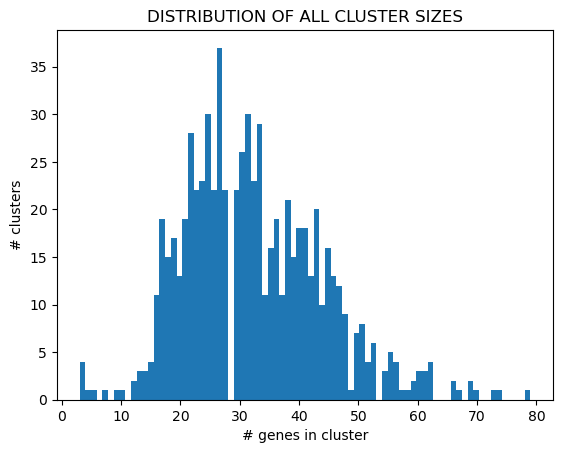

In [10]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

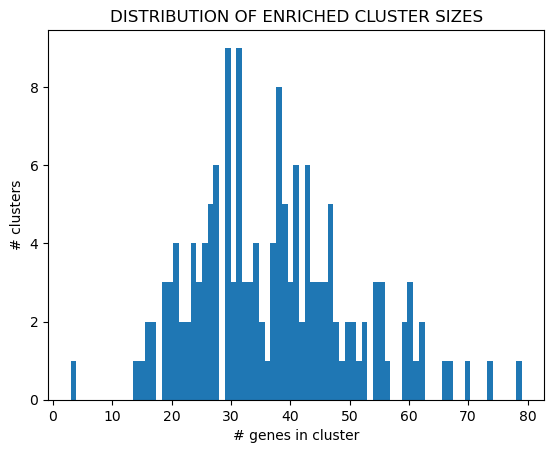

In [11]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [12]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.056239824234715755
                  modularity: 0.7775561078734244
                   nclusters: 712
           mean_cluster_size: 32.46067415730337
         median_cluster_size: 31.0
             sd_cluster_size: 11.755162556788534
          nenriched_clusters: 155
  mean_enriched_cluster_size: 37.13548387096774
median_enriched_cluster_size: 37.0
    sd_enriched_cluster_size: 13.25729375359446
     nenriched_cluster_genes: 5756
                    datetime: 2024-05-19 22:25:59.967610


In [13]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [14]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [15]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [16]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [17]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [18]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [19]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [20]:
# yf_to_ttherm_map_df = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_may2024.csv')
# yf_to_ttherm_map_df.rename(columns={'TTHERM_ID': 'TTHERM_IDs', 'YF_ID': 'TTHERM_ID'},inplace=True)
yf_to_ttherm_map_df = None

In [21]:
import os

embedding_metric = 'manhattan'

In [22]:
full_filtered_norm_df.shape

(23112, 10)

In [23]:
leiden_label_df_round_1_arranged_sorted.shape

(23112, 2)

In [24]:
complete_annot.shape

(26686, 23)

In [25]:
dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a fut

./plots/dashboard374_rna_seq_umap_manhattan_3nn_0.005rp.html


In [26]:
# dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

# p = bokeh_ui_utils.generate_and_save_mds(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

In [27]:
# (HH2A.1, HH2A.2, HH2B.1, HH2B.2, HH3, HH4.1, and HH4.2)
HHs = [
"TTHERM_00189170", "TTHERM_00143660", "TTHERM_00633360", "THERM_00283180", 
]

# (Figure 3A; CPD1, CPD2, and CPG3 and SMC2 and SMC4).
CPD_CPG_SMC = [
"TTHERM_00486070", "TTHERM_00392760", "TTHERM_00919690", "TTHERM_00812950", "TTHERM_0044640", 
]

# cyclin D family members, CYC4, CYC13, and CYC25
cyclin_D_family_members = [
"TTHERM_01043080", "TTHERM_01128530", "TTHERM_00717540",
]

# all cyclins
cyclins = [
'TTHERM_00196590',
'TTHERM_00433390',
'TTHERM_00526250',
'TTHERM_00962160',
'TTHERM_01128530',
'TTHERM_00189230',
'TTHERM_00425970',
'TTHERM_00780580',
'TTHERM_00693080',
'TTHERM_00827080',
'TTHERM_00698650',
'TTHERM_00079530',
'TTHERM_00624450',
'TTHERM_00784350',
'TTHERM_00933270',
'TTHERM_00732460',
'TTHERM_00842480',
'TTHERM_00717540',
'TTHERM_00066840',
'TTHERM_000576939',
'TTHERM_00082190',
'TTHERM_00649450',
'TTHERM_00180970',
'TTHERM_00726380',
'TTHERM_00013060',
'TTHERM_00049420',
'TTHERM_00294860',
'TTHERM_00535270',
'TTHERM_01043080',
'TTHERM_00192000',
'TTHERM_00194440',
'TTHERM_00293270',
'TTHERM_00332170',
'TTHERM_00940290',
]

cyc_subset = [
'TTHERM_00196590', # CYC1 
'TTHERM_00425970', # CYC15
'TTHERM_00624450', # CYC20
'TTHERM_00842480', # CYC24
'TTHERM_00194440', # CYC6
'TTHERM_00332170', # CYC8
]

all_cdks = [
'TTHERM_00411810', #	CDK1
'TTHERM_00318700', #	CDK10
'TTHERM_00576780', #	CDK11
'TTHERM_00267860', #	CDK13
'TTHERM_00394590', #	CDK14
'TTHERM_01035490', #	CDK15
'TTHERM_00624260', #	CDK16
'TTHERM_00066860', #	CDK17
'TTHERM_00784290', #	CDK18
'TTHERM_00339880', #	CDK19
'TTHERM_01347900', #	CDK20
'TTHERM_000837979', #	CDK21
'TTHERM_000937671', #	CDK22
'TTHERM_00011670', #	CDK3
'TTHERM_00286770', #	CDK4
'TTHERM_01080600', #	CDK5
'TTHERM_00837980', #	CDK6
'TTHERM_00133750', #	CDK7
'TTHERM_00717780', #	CDK8
'TTHERM_00185770', #	CDK9
'TTHERM_00483640', #	TCDK3
]

nucleic_acid_metabolic_process = [
'TTHERM_00046490',
'TTHERM_00535470',
'TTHERM_00312260',
'TTHERM_01079170',
'TTHERM_000378989',
'TTHERM_00825460',
'TTHERM_00298220',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00794250',
]

telomere_maintenance = [
'TTHERM_000378989',
'TTHERM_00433640',
'TTHERM_00112560',
'TTHERM_00561799',
]

# DECENT
mitotic_nuclear_division = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

mitotic_cell_cycle = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

chromosome_organization = [
'TTHERM_00088010',
'TTHERM_00307700',
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00189170',
'TTHERM_00790790',
'TTHERM_00316500',
'TTHERM_00143660',
'TTHERM_00633360',
'TTHERM_00283180',
'TTHERM_00316410',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00455130',
'TTHERM_000378989',
'TTHERM_00726370',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
]

DNA_repair = [
'TTHERM_00307700',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00312260',
'TTHERM_00316410',
'TTHERM_00439320',
'TTHERM_01050440',
'TTHERM_01079170',
'TTHERM_01106120',
'TTHERM_00726470',
'TTHERM_00455309',
'TTHERM_00825460',
'TTHERM_00726370',
'TTHERM_00142290',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00888060',
'TTHERM_00864890',
'TTHERM_00829440',
'TTHERM_00794250',
]

microtubule_cytoskeleton_organi = [
'TTHERM_00335970'
'TTHERM_00426160'
'TTHERM_01220340'
'TTHERM_00522990'
'TTHERM_00338260'
'TTHERM_000727749'
'TTHERM_000123789'
'TTHERM_000161298'
'TTHERM_00030040'
'TTHERM_000357129'
'TTHERM_00046500'
'TTHERM_000488189'
'TTHERM_000706399'
'TTHERM_00088040'
'TTHERM_00133700'
'TTHERM_00266668'
'TTHERM_00346790'
'TTHERM_00452020'
'TTHERM_00493000'
'TTHERM_00755750'
'TTHERM_00842510'
'TTHERM_00992710'
]

# all MCMs
all_MCMs = [
'TTHERM_00554270',
'TTHERM_00092850',
'TTHERM_00277550',
'TTHERM_00069420',
'TTHERM_00448570',
'TTHERM_00011740',
'TTHERM_01031060',
'TTHERM_00703910',
'TTHERM_01207610',
]

MCM_subset = ['YF00026324.1', 'YF00025215.1', 'YF00018584.1', 'YF00012156.1']
# YF00026324, YF00025215, YF00018584, YF00012156
# MCM5, MCM6, MCM3, MCM2

mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

histones = ['TTHERM_00146340', 'TTHERM_00446570', 'TTHERM_00498190', 'TTHERM_00189170', 'TTHERM_00189180', 'TTHERM_00016170', 'TTHERM_00016200', 'TTHERM_00790790', 'TTHERM_00316500', 'TTHERM_00143660', 'TTHERM_01079200', 'TTHERM_00633360', 'TTHERM_00283180', 'TTHERM_00354710', 'TTHERM_00474790', 'TTHERM_00852840', 'TTHERM_01194650']

In [28]:
gene_lists = {}
gene_lists = {
'HHs': HHs,
'CPD_CPG_SMC': CPD_CPG_SMC,
'cyclin_D_family_members': cyclin_D_family_members,
'cyclins': cyclins,
'cyc_subset': cyc_subset,
'all_cdks': all_cdks,
'nucleic_acid_metabolic_process': nucleic_acid_metabolic_process,
'telomere_maintenance': telomere_maintenance,
'mitotic_nuclear_division': mitotic_nuclear_division,
'mitotic_cell_cycle': mitotic_cell_cycle,
'chromosome_organization': chromosome_organization,
'DNA_repair': DNA_repair,
'microtubule_cytoskeleton_organi': microtubule_cytoskeleton_organi,
'all_MCMs': all_MCMs,
'MCM_subset': MCM_subset,
'mucocyst_cluster': mucocyst_cluster,
'histones' : histones,
}

In [29]:
xls_files = glob('../../new_raw_data/rna_seq_processed/xls_files/*.xls')
sorted(xls_files)

['../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s01.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s02.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s03.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s04.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s05.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s06.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s07.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s08.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s09.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s10.xls']

In [30]:
for xls_file in xls_files:
    excel_file = pd.read_excel(xls_file, sheet_name=None)
    for sheet_name, df in excel_file.items():
        target_ids = []
        gene_cluster_assignments_mode_only = None

        first_column = list(df.iloc[:, 0].values)

        if sheet_name in gene_lists:
            name_num = 0
            new_sheet_name = sheet_name
            while new_sheet_name in gene_lists:
                name_num += 1
                new_sheet_name = f'{sheet_name}_{name_num}'
            print(f'WARNING: DUPLICATE GENE LIST NAME: \'{sheet_name}\'. RENAMING TO \'{new_sheet_name}\'.')
            sheet_name = new_sheet_name

        gene_lists[sheet_name] = first_column

In [31]:
fraction_threshold = 0.1

clustering_utils.multi_fraction_max_same_cluster_genes(gene_lists, leiden_label_df_round_1_arranged_sorted, fraction_threshold=fraction_threshold, print_mode=True)

GENE_LIST: HHs
THERM_00283180
2 / 2 = 1.0
             TTHERM_ID  label
14534  TTHERM_00633360    204
4253   TTHERM_00189170    204
TTHERM_00633360,TTHERM_00189170



GENE_LIST: CPD_CPG_SMC
TTHERM_0044640
1 / 1 = 1.0
             TTHERM_ID  label
19047  TTHERM_00919690    209
TTHERM_00919690



GENE_LIST: cyclin_D_family_members
1 / 1 = 1.0
             TTHERM_ID  label
16411  TTHERM_00717540    508
TTHERM_00717540



GENE_LIST: cyclins
TTHERM_000576939
TTHERM_00535270
1 / 10 = 0.1
            TTHERM_ID  label
4679  TTHERM_00196590     86
TTHERM_00196590



GENE_LIST: cyc_subset
1 / 1 = 1.0
            TTHERM_ID  label
4679  TTHERM_00196590     86
TTHERM_00196590



GENE_LIST: all_cdks
TTHERM_000937671
1 / 6 = 0.16666666666666666
             TTHERM_ID  label
16431  TTHERM_00717780    110
TTHERM_00717780



GENE_LIST: nucleic_acid_metabolic_process
TTHERM_000378989
1 / 5 = 0.2
             TTHERM_ID  label
17664  TTHERM_00794250    204
TTHERM_00794250



GENE_LIST: telomere_maintenance

In [32]:
','.join(cyclins)

'TTHERM_00196590,TTHERM_00433390,TTHERM_00526250,TTHERM_00962160,TTHERM_01128530,TTHERM_00189230,TTHERM_00425970,TTHERM_00780580,TTHERM_00693080,TTHERM_00827080,TTHERM_00698650,TTHERM_00079530,TTHERM_00624450,TTHERM_00784350,TTHERM_00933270,TTHERM_00732460,TTHERM_00842480,TTHERM_00717540,TTHERM_00066840,TTHERM_000576939,TTHERM_00082190,TTHERM_00649450,TTHERM_00180970,TTHERM_00726380,TTHERM_00013060,TTHERM_00049420,TTHERM_00294860,TTHERM_00535270,TTHERM_01043080,TTHERM_00192000,TTHERM_00194440,TTHERM_00293270,TTHERM_00332170,TTHERM_00940290'